In [17]:
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature
import geopandas
%matplotlib inline

In [18]:
cmap_name = 'StepSeq25'
rgb = np.genfromtxt("other-files/colourmaps/{}.rgb".format(cmap_name))/255.
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb, N=25)

In [19]:
seasons = [1,2], [4,5], [7,8], [10,11]

In [20]:
months = []
sw = []
t2 = []

In [21]:
for year in range(2010,2011):
	print(year)
	swinfile = Dataset("../era5/data/{}_mean_surface_downward_short_wave_radiation_flux.nc".format(year))
	t2infile = Dataset("../era5/data/{}_2m_temperature.nc".format(year))

	sw_data = swinfile.variables['msdwswrf'][:]
	if year >= 2022:
		sw_data = sw_data[:,0]
	sw.extend(sw_data)
	
	t2_data = t2infile.variables['t2m'][:]-273.15
	if year >= 2022:
		t2_data = t2_data[:,0]
	t2.extend(t2_data)

	lons = swinfile.variables['longitude'][:] 
	lats = swinfile.variables['latitude'][:]

	time = t2infile.variables['time']
	times = num2date(time[:], time.units)
	months.extend(np.array([t.month for t in times]))

2010


In [22]:
sw = np.array(sw)
t2 = np.array(t2)
months = np.array(months)

In [23]:
T_ref = 25. 
eff_ref = 0.9 
beta_ref = 0.0042
G_ref = 1000.
 
rel_efficiency_of_panel = eff_ref*(1 - beta_ref*(t2 - T_ref))
capacity_factor_of_panel = np.nan_to_num(rel_efficiency_of_panel*
                                        (sw/G_ref)) 

In [24]:
mean_capacity = capacity_factor_of_panel.mean(axis=0)
print(mean_capacity.min(), mean_capacity.max())

0.10728661308777457 0.2773929881427706


In [25]:
#np.save("data/means/solarcapacity", mean_capacity)

In [32]:
plt.ioff()

fig = plt.figure(figsize=(15,8))

ax1 = plt.subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax2 = plt.subplot(2,4,3, projection=cartopy.crs.PlateCarree())
ax3 = plt.subplot(2,4,4, projection=cartopy.crs.PlateCarree())
ax4 = plt.subplot(2,4,7, projection=cartopy.crs.PlateCarree())
ax5 = plt.subplot(2,4,8, projection=cartopy.crs.PlateCarree())

axes = [ax1,ax2,ax3,ax4,ax5]


In [33]:
cs = ax1.pcolormesh(lons, lats, mean_capacity, cmap=cmap, vmin=0, vmax=0.5, rasterized=True)

df = geopandas.read_file("other-files/india_states_lores.zip")
df.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=0.25)


fig.subplots_adjust(bottom=0.185, wspace=.1, hspace=.125)
cax = plt.gcf().add_axes([0.175, 0.1, 0.25, 0.025])
cb = plt.colorbar(cs, cax=cax, orientation='horizontal', extend='max')
cb.set_label("Mean hourly capacity factor (solar)")

In [34]:
for season, ax in zip(seasons, [ax2,ax3,ax4,ax5]):
	it = np.in1d(months, season)
	mean_capacity = capacity_factor_of_panel[it].mean(axis=0)
	ax.pcolormesh(lons, lats, mean_capacity, cmap=cmap, vmin=0, vmax=0.5, rasterized=True)
	
ax1.set_title("Annual mean")	
ax2.set_title("Winter (Jan-Feb)")	
ax3.set_title("Pre-monsoon (Apr-May)")	
ax4.set_title("Monsoon (Jul-Aug)")	
ax5.set_title("Post-monsoon (Oct-Nov)")	

Text(0.5, 1.0, 'Post-monsoon (Oct-Nov)')

In [35]:
for ax in ax1, ax4, ax5:
	ax.set_xticks(np.arange(0,100,10))
	ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)

for ax in ax3, ax5:
	ax.set_yticks(np.arange(0,100,10))
	ax.yaxis.tick_right()
	ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax1.set_yticks(np.arange(0,100,10))
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)

shape_feature = ShapelyFeature(shapereader.Reader("other-files/ne_10m_admin_0_countries_ind.shp").geometries(),
                               cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', lw=0.75)


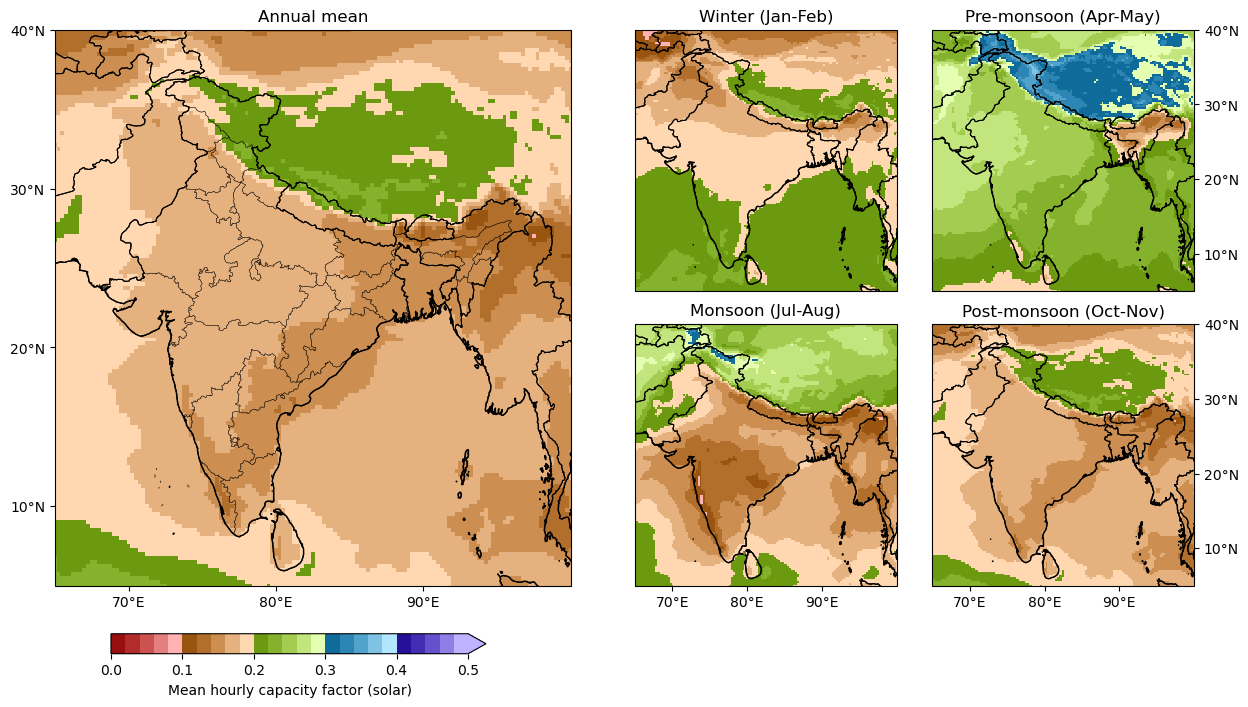

In [36]:
for ax in axes:
	ax.coastlines()
	ax.add_feature(shape_feature)
	ax.set_xlim([lons.min(), lons.max()])
	ax.set_ylim([lats.min(), lats.max()])



plt.show()
